## **Ouliers detection**

*Observation which deviates so much from other observations as to arouse suspicion it was generated by a different mechanism*<br>
*--- Hawkings (1980)*

Outliers are extreme values that deviate from other observations on data , they may indicate a variability in a measurement, experimental errors or a novelty. In other words, an **outlier is an observation that diverges from an overall pattern on a sample.** Outliers can be of two kinds: univariate and multivariate. Univariate outliers can be found when looking at a distribution of values in a single feature space. Multivariate outliers can be found in a n-dimensional space (of n-features). Looking at distributions in n-dimensional spaces can be very difficult for the human brain, that is why we need to train a model to do it for us.

Outliers can also come in different flavours, depending on the environment: point outliers, contextual outliers, or collective outliers. Point outliers are single data points that lay far from the rest of the distribution. Contextual outliers can be noise in data, such as punctuation symbols when realizing text analysis or background noise signal when doing speech recognition. Collective outliers can be subsets of novelties in data such as a signal that may indicate the discovery of new phenomena.

In the process of producing, collecting, processing and analyzing data, outliers can come from many sources and hide in many dimensions. Those that are not a product of an error are called **novelties**. Detecting outliers is of major importance for almost any quantitative discipline (ie: Physics, Economy, Finance, Machine Learning, Cyber Security). In machine learning and in any quantitative discipline the quality of data is as important as the quality of a prediction or classification model.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime as dt

import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', palette='deep', font_scale=1.2)
pd.options.mode.chained_assignment = None  # default='warn'

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf

In [ ]:
# Block to load file depending if you are in Colab or in Jupyter
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    !nvidia-smi
    TF_CPP_MIN_LOG_LEVEL=2

    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
      raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
    # get data
    !wget --no-check-certificate \
        https://www.dropbox.com/s/9tc40rtuiw5lvh7/00.57.FE.0E.csv?dl=0 \
        -O /tmp/00.57.FE.0E.csv
    !wget --no-check-certificate \
        https://www.dropbox.com/s/xm4q3n1mfzwjzft/29.E5.5A.24.csv?dl=0 \
        -O /tmp/29.E5.5A.24.csv
    !wget --no-check-certificate \
        https://www.dropbox.com/s/7sa2dk2iyse0xuc/34.B2.9F.A9.csv?dl=0 \
        -O /tmp/34.B2.9F.A9.csv
    !wget --no-check-certificate \
        https://www.dropbox.com/s/nj741a2kw20uqp3/A7.CB.0A.C0.csv?dl=0 \
        -O /tmp/A7.CB.0A.C0.csv
        
    sensor_1 = pd.read_csv('/tmp/00.57.FE.0E.csv', parse_dates=['Timestamp'], index_col='Timestamp')
    sensor_2 = pd.read_csv('/tmp/29.E5.5A.24.csv', parse_dates=['Timestamp'], index_col='Timestamp')
    sensor_3 = pd.read_csv('/tmp/34B29FA9.csv', parse_dates=['Timestamp'], index_col='Timestamp')
    sensor_4 = pd.read_csv('/tmp/A7.CB.0A.C0.csv', parse_dates=['Timestamp'], index_col='Timestamp')
else:
    sensor_1 = pd.read_csv('/Data/00.57.FE.0E.csv', parse_dates=['Timestamp'], index_col='Timestamp')
    sensor_2 = pd.read_csv('/Data/29.E5.5A.24.csv', parse_dates=['Timestamp'], index_col='Timestamp')
    sensor_3 = pd.read_csv('/Data/34B29FA9.csv', parse_dates=['Timestamp'], index_col='Timestamp')
    sensor_4 = pd.read_csv('/Data/A7.CB.0A.C0.csv', parse_dates=['Timestamp'], index_col='Timestamp')

## Helper Functions

In [2]:
def get_module_feature(module, features, path_of_file, numerical=False):
    
    df = pd.read_csv(path_of_file, parse_dates=['Timestamp'], index_col='Timestamp')
    
    try:
        df = df.drop(['Unnamed: 0'],axis=1)
    except:
        pass
    if numerical:
        return np.array(df[df['Module']==module][[features]])
    else:
        return df[df['Module']==module][[features]]

def split_sequences(X_train, feature_index=0, n_steps=32):

    '''
    Split a multivariate sequence into samples for single feature prediction
    Taken and adapted from Machinelearningmastery.
    Split the training set into segments of a specified timestep
    and creates the labels.
    '''
    n_steps = n_steps+1
    # Place the column of the feature to predict at the end of the dataset
    sequences = np.concatenate([X_train, X_train[:,feature_index].reshape(-1,1)],axis=1)

    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix-1, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)

    #print(np.shape(X),np.shape(y))
    return np.array(X), np.array(y)

def get_abs_err(X, y, model, std=3, plot=True, n_outputs=6):
    '''
    get the absolute error between prediction and labels
    and the threshold. Plots the error distribution also.
    '''
    x_pred = model.predict(X)

    if np.shape(y)[-1] == n_outputs:
        abs_err = np.asarray(abs(x_pred - y))
        threshold = abs_err[0,:].std()*std
        if plot==True:
            fig, (ax1) = plt.subplots(1, 1, figsize=(10,4))
            sns.distplot(abs_err[0,:], ax=ax1, label='Error distribution')
            plt.axvline(x=threshold, ymin=0, ymax=8, color='r', label='Threshold')
            plt.title('Error distribution, threshold set in {}'. format(threshold.round(4)))
            #plt.xticks(np.arange(0,1.1,0.1))
            plt.legend(); plt.tight_layout()
            return pd.DataFrame(abs_err), threshold
        else:
            return pd.DataFrame(abs_err), threshold
    else:
        abs_err = np.asarray(abs(x_pred - y.reshape(-1,1)))
        threshold = abs_err.std()*std
        if plot==True:
            fig, (ax1) = plt.subplots(1, 1, figsize=(10,4))
            sns.distplot(abs_err, ax=ax1, label='Error distribution')
            plt.axvline(x=threshold, ymin=0, ymax=8, color='r', label='Threshold')
            plt.title('Error distribution, threshold set in {}'. format(threshold.round(4)))
            #plt.xticks(np.arange(0,1.1,0.1))
            plt.legend(); plt.tight_layout()
            return pd.Series(abs_err.reshape(-1)), threshold
        else:
            return pd.Series(abs_err.reshape(-1)), threshold
        
def get_anomaly_and_pred(model, X, y, threshold, test_data, n_features=6, feature=0):

    index=test_data.index[64:]
    if np.shape(y)[-1] == n_features:
        predictions = np.concatenate((model.predict(X)[:,feature].reshape(-1,1), y[:,feature].reshape(-1,1)), axis=1)
    else:
        predictions = np.concatenate((model.predict(X), y.reshape(-1,1)), axis=1)

    predictions_df = pd.DataFrame(data=predictions, columns=['Pred','True'], index=index)
    predictions_df['error'] = abs(predictions_df['True'] - predictions_df['Pred'])

    dates_index = predictions_df['error'].loc[predictions_df.error >= threshold].index

    anomaly = pd.Series(data=np.zeros(shape=(test_data.shape[0])), index=test_data.index, name='anomalies')
    anomaly.loc[dates_index] = predictions_df['error'].loc[predictions_df.error >= threshold].values.astype(bool)
    #print('Anomalies founded {}'.format(anomaly.value_counts()[1]))

    return predictions_df, anomaly

def plot_anomalies_model(data, test_date, anomalies, module_label='34.B2.9F.A9'):

    # data and anomaly are dataframes
    fig = plt.figure(figsize=(24,4))
    spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1, 3])

    ax0 = fig.add_subplot(spec[0])
    sns.distplot(a=data[test_date:]['Temp_Mod'], kde=False, ax=ax0, label='Data')
    sns.distplot(a=data[data['anomaly_LSTM']==1]['Temp_Mod'], kde=False, color='darkred', ax=ax0, label='LSTM')
    ax0.legend()

    ax1 = fig.add_subplot(spec[1])
    sns.lineplot(data[test_date:].index, data[test_date:]['Temp_Mod'], label='Data', ax=ax1)
    ax1.scatter(data[data['anomaly_LSTM']==1].index, data[data['anomaly_LSTM']==1]['Temp_Mod'], color='red', s=30, label='LSTM anomalies')
    ax1.set_title('Anomalies detected in module {}'.format(module_label))
    ax1.legend()
    plt.tight_layout()

In [3]:
def create_train_test(slice_of_data, resample_time='5Min', feature_index=0, feature_name='Temp_Mod', scaler=StandardScaler(),
                      final_date='2019-01-20 00:00:05', split_date = '2019-01-01 00:00:05', test_date = '2019-01-17 00:00:05',
                      figsize=(20,4), plot=True):
    '''
    The passed dataset must have a timestamp as index.
    Resamples the dataset into a given freq (default 5 min) using
    rolling mean and split it into training and testing dataframes.
    Scales the data using Sklearn Standard Scaler and returns the
    numpy arrays of the x_train, y_train, x_test, y_test.

    slice_of_data: data to be splitted
    feature_index: index of the feature to be predicted (for y_train and test)
    feature_name: name of the feature in dataset
    final_date: date limit to split
    split_date: date to start splitting
    test_date: starting test date

    data: dataframe with all the resampled data, combines train and test
    '''

    # Resample to 5 min with rolling mean
    slice_of_data = slice_of_data.resample(resample_time).mean()
    # Method Backward Fill
    slice_of_data = slice_of_data.fillna(slice_of_data.bfill())

    data = slice_of_data.loc[split_date:final_date]
    train_data = slice_of_data.loc[split_date:test_date]
    test_data = slice_of_data.loc[test_date:final_date]

    #Scale the data to unit variance. We only fit in the Training data
    #scaler = StandardScaler()
    # Scale the data and convert it into dataframe for easy splitting
    X_train = pd.DataFrame(scaler.fit_transform(train_data), columns=[slice_of_data.columns]).to_numpy()
    X_test = pd.DataFrame(scaler.transform(test_data), columns=[slice_of_data.columns]).to_numpy()

    # Since i'm going to predict only temperature
    y_train, y_test = X_train[:,feature_index], X_test[:,feature_index]
    if plot==True:
        fig, axx = plt.subplots(1,1)
        slice_of_data.loc[split_date:test_date][feature_name].plot(ax=axx, figsize=figsize, label='Train')
        slice_of_data.loc[test_date:final_date][feature_name].plot(ax=axx,figsize=figsize, title=('Resampled Data to {}'.format(resample_time)), color='r', label='Test')
        plt.legend(); plt.tight_layout()

    return data, train_data, test_data, X_train, X_test, y_train, y_test, scaler

def plot_model_results(model, history_df, X, y, index, feature_index=0):
    '''
    Plot the scores of the model and the prediction vs the
    real time series
    '''
    prediction = model.predict(X)
    if prediction.shape[-1] == 1:
        pred_df = pd.DataFrame(data= np.concatenate((model.predict(X), y.reshape(-1,1)), axis=1), columns=['Prediction', 'True'], index=index)
    else:
        pred_df = pd.DataFrame(data= np.concatenate((model.predict(X)[:,feature_index].reshape(-1,1), y[:,feature_index].reshape(-1,1)), axis=1), columns=['Prediction', 'True'], index=index)

    fig = plt.figure(figsize=(24,5))
    spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1, 3])
    ax0 = fig.add_subplot(spec[0])
    sns.lineplot(data=history_df[['loss','val_loss']], markers=True)
    # plot the prediction and the reality (for the test data)
    ax1 = fig.add_subplot(spec[1])
    pred_df.plot(ax=ax1)
    plt.legend(loc='upper left')
    plt.title('Prediction and Truth (Scaled)')
    plt.tight_layout()

### Getting the Data

In [4]:
from matplotlib import gridspec

In [5]:
def anomalies(module='34.B2.9F.A9'):

    final_date='2019-02-20 00:00:05'
    split_date = '2018-10-01 00:00:05'
    test_date = '2019-01-16 00:00:05'
    resample_time = '5Min'

    sensor = get_module_feature(module, features='Temp_Mod', path_of_file='../../Features.csv')
    
    # Splitting by date, saving a part for testing
    data, train_data, test_data, X_train, X_test, y_train, y_test, scaler = \
    create_train_test(sensor, final_date=final_date, split_date=split_date, test_date=test_date,
                          resample_time=resample_time, figsize=(24,5), scaler=MinMaxScaler(), plot=False)

    # How many timestamps in the past to make a single prediction
    timesteps = 64
    X_train_seg, y_train_seg = split_sequences(X_train, feature_index=0, n_steps=timesteps)
    X_test_seg, y_test_seg = split_sequences(X_test, feature_index=0, n_steps=timesteps)

    n_features, n_timesteps, n_samples  = X_train_seg.shape[-1], X_train_seg.shape[-2], X_train_seg.shape[0]
    n_outputs_s, n_outputs_m = 1, X_train_seg.shape[-1] 
    n_predictions = 1
    #print('Number of Samples {} -> Number of timesteps {} -> Number of features {}'.format(n_samples, n_timesteps, n_features))

    # define model
    # create multiple models
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(64, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True))
    model.add(tf.keras.layers.LSTM(64, activation='relu', return_sequences=False))
    model.add(tf.keras.layers.Dense(128, activation='linear'))
    #model.add(Dropout(0.2))
    model.add(tf.keras.layers.Dense(n_outputs_s, activation='linear'))
    model.compile(optimizer='adam', loss='mae')
    #model.summary()

    # Hyper-parameters
    BATCH_SIZE = 256
    EPOCHS = 30
    callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='auto', verbose=1)]

    # Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
    history = model.fit(x=X_train_seg, y=y_train_seg, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                        callbacks=callbacks_list, validation_split=0.1, verbose=0)
    history_df = pd.DataFrame(history.history)

    # create the list of difference between prediction and test data
    abs_err_train, threshold = get_abs_err(X_train_seg, y_train_seg, model, std=5, plot=False)
    abs_err_test, _ = get_abs_err(X_test_seg, y_test_seg, model, plot=False)

    predictions_df, anomalies_LSTM = get_anomaly_and_pred(model, X_test_seg, y_test_seg, threshold, test_data)
    data['anomaly_LSTM'] = anomalies_LSTM
    data['anomaly_LSTM'] = data['anomaly_LSTM'].fillna(0) # Fill the rest with 0
    print(data[data['anomaly_LSTM']==1][['Temp_Mod']].describe().transpose())
    plot_anomalies_model(data, test_date, anomalies_LSTM, module_label=module)
    plt.tight_layout()

In [8]:
sensor = get_module_feature('A7.CB.0A.C0', features='Temp_Mod', path_of_file='../../Features.csv')
sensor.to_csv('../Data/A7.CB.0A.C0.csv', index_label='Timestamp')

Epoch 00010: early stopping
          count       mean       std   min    25%   50%     75%   max
Temp_Mod   90.0  36.640556  4.906994  25.6  33.45  36.9  41.075  45.0
Epoch 00007: early stopping
          count       mean       std   min      25%   50%    75%   max
Temp_Mod   82.0  32.121951  3.456503  25.1  30.1875  31.9  34.85  39.9
Epoch 00014: early stopping
          count       mean       std        min        25%        50%     75%  \
Temp_Mod   44.0  38.032197  6.005409  24.366667  35.291667  39.283333  43.025   

            max  
Temp_Mod  46.05  


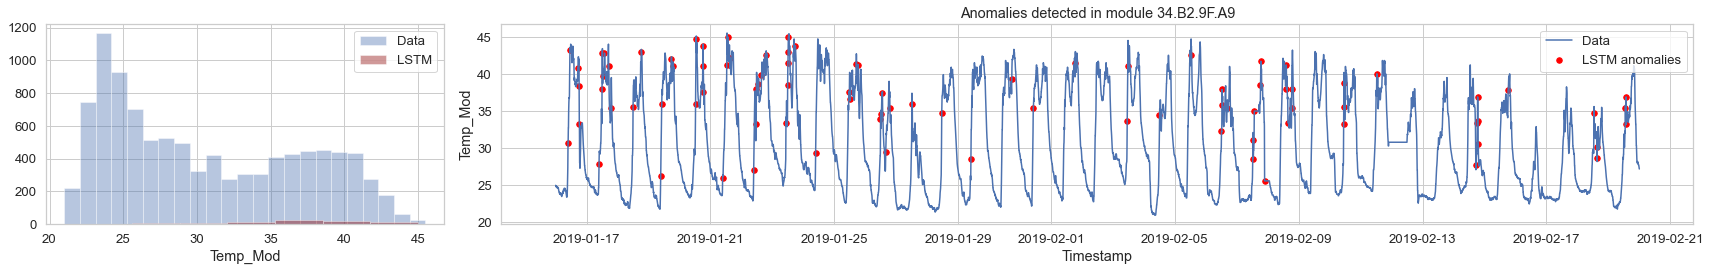

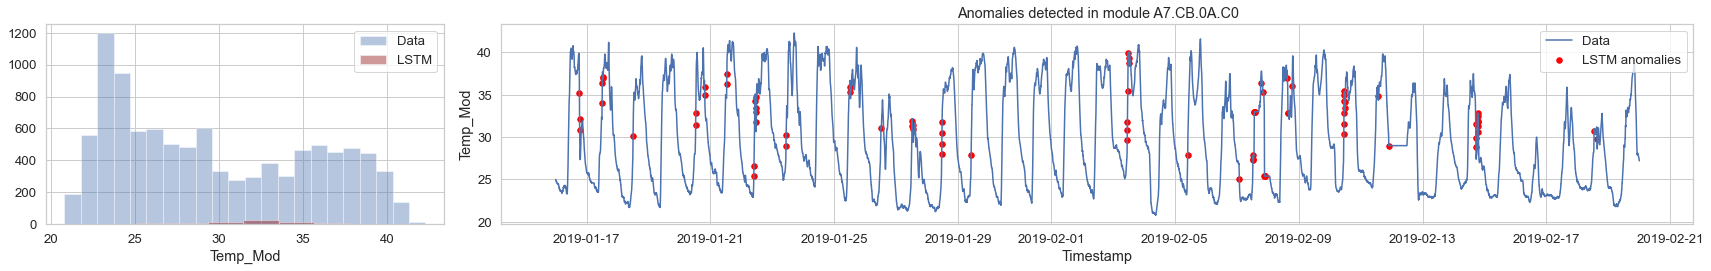

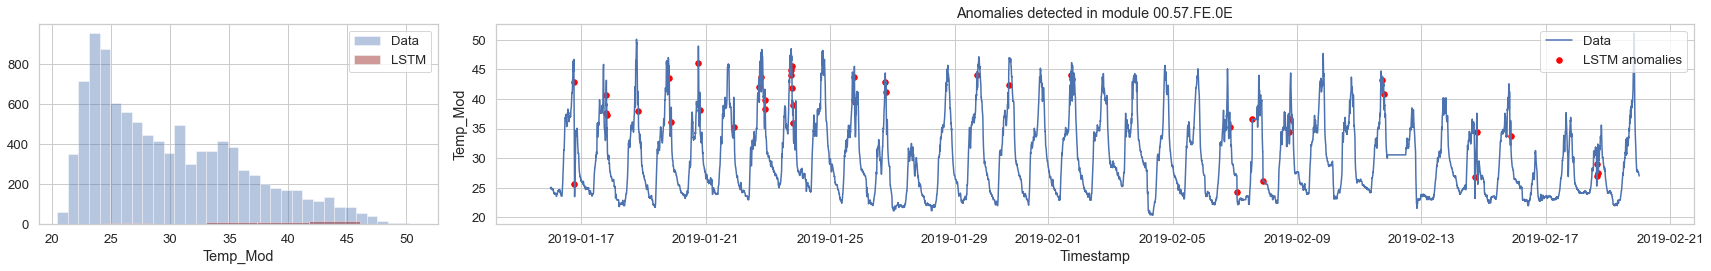

In [92]:
anomalies(module='34.B2.9F.A9')  # Communicates with router 00.57.FE.0E
anomalies(module='A7.CB.0A.C0')  # Communicates with router 00.57.FE.0E
anomalies(module='00.57.FE.0E')
#anomalies(module='29.E5.5A.24')